In [39]:
from src.data import DataLoaders
from src import utils
import pathlib
import pandas as pd
from src.models.ModelClasses import FireRiskModels, SmokeAlarmModels
from matplotlib import pyplot as plt
from pathlib import Path
from datetime import date
import numpy as np
#import geopandas as geo
import folium

In [40]:
ACS =  DataLoaders.ACSData(2016,'block_group', 0)

In [41]:
ACS.data

,state,tot_population,in_poverty,inc_pct_poverty,inc_pcincome,race_pct_white,race_pct_whitenh,race_pct_nonwhite,race_pct_nonwhitenh,race_pct_black,...,house_yr_pct_before_1960,house_yr_pct_after_2000,house_yr_pct_1960_2000,house_val_less_50K,house_val_50_100K,house_val_100K_300K,house_val_300K_500K,house_val_more_500K,race_pct_black_or_amind,pct_alt_heat
GEOID,,,,,,,,,,,,,,,,,,,,,
010010201001,AL,745.0,143.0,0.191946,20365.0,0.785235,0.763758,0.214765,0.236242,0.214765,...,0.221831,0.193662,0.584507,0.152047,0.274854,0.508772,0.064327,0.000000,0.214765,0.017606
010010201002,AL,1265.0,56.0,0.044269,33336.0,0.856126,0.826877,0.143874,0.173123,0.082213,...,0.079229,0.085653,0.835118,0.100264,0.153034,0.538259,0.174142,0.034301,0.082213,0.032895
010010202001,AL,955.0,365.0,0.382199,17047.0,0.376042,0.376042,0.623958,0.623958,0.591667,...,0.135678,0.211055,0.653266,0.171053,0.337719,0.394737,0.065789,0.030702,0.591667,0.000000
010010202002,AL,1059.0,118.0,0.111426,21400.0,0.497573,0.488673,0.502427,0.511327,0.461974,...,0.235772,0.075203,0.689024,0.053691,0.513423,0.412752,0.020134,0.000000,0.461974,0.019912
010010203001,AL,2364.0,100.0,0.042301,23106.0,0.626481,0.626481,0.373519,0.373519,0.217851,...,0.030303,0.091887,0.877810,0.057522,0.349558,0.592920,0.000000,0.000000,0.227157,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560459511001,WY,1457.0,137.0,0.094029,33781.0,0.950583,0.929307,0.049417,0.070693,0.000000,...,0.308305,0.121729,0.569966,0.089320,0.114563,0.666019,0.091262,0.038835,0.000000,0.366569
560459511002,WY,1582.0,99.0,0.062579,34002.0,0.935884,0.918642,0.064116,0.081358,0.009698,...,0.197500,0.337500,0.465000,0.123438,0.079687,0.525000,0.232812,0.039062,0.014547,0.825737
560459513001,WY,1151.0,301.0,0.261512,23326.0,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.556757,0.000000,0.443243,0.229282,0.303867,0.466851,0.000000,0.000000,0.000000,0.105163


In [42]:
NFIRS = DataLoaders.NFIRSData('block_group',ACS.tot_pop)
NFIRS_Sev = DataLoaders.NFIRSData('block_group',ACS.tot_pop, sev=True)

C:\Users\cle9a\Documents\rcp2_2_18_2022\src\data\DataLoaders.py:205: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  self.Load()


In [43]:
NFIRS.fires

,2009,2010,2011,2012,2013,2014,2015,2016,2017
geoid,,,,,,,,,
010010201001,1.342282,2.684564,NaN,NaN,NaN,NaN,NaN,1.342282,1.342282
010010201002,1.581028,0.790514,NaN,1.581028,0.790514,NaN,1.581028,0.790514,NaN
010010202001,1.047120,NaN,3.141361,NaN,1.047120,1.047120,1.047120,1.047120,NaN
010010202002,2.832861,2.832861,2.832861,0.944287,0.944287,NaN,0.944287,NaN,3.777148
010010203001,0.846024,1.269036,0.846024,0.423012,1.269036,0.423012,0.423012,0.846024,NaN
...,...,...,...,...,...,...,...,...,...
560459511001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.372684,NaN
560459511002,0.632111,NaN,NaN,NaN,NaN,NaN,0.632111,NaN,NaN
560459513001,0.868810,NaN,0.868810,NaN,0.868810,0.868810,NaN,NaN,1.737619


In [44]:
ACS_cols_to_use =[ 'did_not_work_past_12_mo',
               'house_pct_live_alone',
               'pct_alt_heat',
               'house_yr_pct_before_1960',
               'inc_pct_poverty',
               'race_pct_black_or_amind']

In [45]:
ACS_cols = ACS.data[ACS_cols_to_use]
ACS_cols

,did_not_work_past_12_mo,house_pct_live_alone,pct_alt_heat,house_yr_pct_before_1960,inc_pct_poverty,race_pct_black_or_amind
GEOID,,,,,,
010010201001,0.355019,0.221831,0.017606,0.221831,0.191946,0.214765
010010201002,0.309021,0.127193,0.032895,0.079229,0.044269,0.082213
010010202001,0.509589,0.344560,0.000000,0.135678,0.382199,0.591667
010010202002,0.309886,0.338496,0.019912,0.235772,0.111426,0.461974
010010203001,0.294054,0.276699,0.000000,0.030303,0.042301,0.227157
...,...,...,...,...,...,...
560459511001,0.301663,0.324047,0.366569,0.308305,0.094029,0.000000
560459511002,0.288010,0.258713,0.825737,0.197500,0.062579,0.014547
560459513001,0.232123,0.330784,0.105163,0.556757,0.261512,0.000000


In [46]:
FSM =  FireRiskModels('severity')
FPM =  FireRiskModels('propensity')

In [47]:
NFIRS.fires

,2009,2010,2011,2012,2013,2014,2015,2016,2017
geoid,,,,,,,,,
010010201001,1.342282,2.684564,NaN,NaN,NaN,NaN,NaN,1.342282,1.342282
010010201002,1.581028,0.790514,NaN,1.581028,0.790514,NaN,1.581028,0.790514,NaN
010010202001,1.047120,NaN,3.141361,NaN,1.047120,1.047120,1.047120,1.047120,NaN
010010202002,2.832861,2.832861,2.832861,0.944287,0.944287,NaN,0.944287,NaN,3.777148
010010203001,0.846024,1.269036,0.846024,0.423012,1.269036,0.423012,0.423012,0.846024,NaN
...,...,...,...,...,...,...,...,...,...
560459511001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.372684,NaN
560459511002,0.632111,NaN,NaN,NaN,NaN,NaN,0.632111,NaN,NaN
560459513001,0.868810,NaN,0.868810,NaN,0.868810,0.868810,NaN,NaN,1.737619


In [48]:
FPM.train(NFIRS,ACS,ACS_cols_to_use)

C:\Users\cle9a\Documents\rcp2_2_18_2022\src\models\ModelClasses.py:179: RuntimeWarning: All-NaN axis encountered
  mx = np.nanmax(X, axis =1)
C:\Users\cle9a\anaconda3\envs\rcp2Lite\lib\site-packages\numpy\lib\nanfunctions.py:1120: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


Predicting 2017:
[11:37:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\cle9a\anaconda3\envs\rcp2Lite\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[[159423  46995]
 [  2319   9002]]
0.8671176533418194
              precision    recall  f1-score   support

       False       0.99      0.77      0.87    206418
        True       0.16      0.80      0.27     11321

    accuracy                           0.77    217739
   macro avg       0.57      0.78      0.57    217739
weighted avg       0.94      0.77      0.83    217739

Feature ranking:
1. Max (0.427508)
2. Median (0.136157)
3. pct_alt_heat (0.082652)
4. house_pct_live_alone (0.077553)
5. inc_pct_poverty (0.072500)
6. race_pct_black_or_amind (0.069879)
7. house_yr_pct_before_1960 (0.068611)
8. did_not_work_past_12_mo (0.065140)


In [49]:
FPM.years_used

array(['2011', '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype=object)

In [50]:
FSM.train(NFIRS_Sev,ACS,ACS_cols_to_use)

C:\Users\cle9a\Documents\rcp2_2_18_2022\src\models\ModelClasses.py:179: RuntimeWarning: All-NaN axis encountered
  mx = np.nanmax(X, axis =1)
C:\Users\cle9a\anaconda3\envs\rcp2Lite\lib\site-packages\numpy\lib\nanfunctions.py:1120: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


Predicting 2017:
[11:37:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\cle9a\anaconda3\envs\rcp2Lite\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[[163538  50467]
 [  1023   2711]]
0.8247673226252403
              precision    recall  f1-score   support

       False       0.99      0.76      0.86    214005
        True       0.05      0.73      0.10      3734

    accuracy                           0.76    217739
   macro avg       0.52      0.75      0.48    217739
weighted avg       0.98      0.76      0.85    217739

Feature ranking:
1. Median (0.355454)
2. Max (0.195376)
3. pct_alt_heat (0.077562)
4. race_pct_black_or_amind (0.077486)
5. house_pct_live_alone (0.076930)
6. did_not_work_past_12_mo (0.074547)
7. house_yr_pct_before_1960 (0.072959)
8. inc_pct_poverty (0.069686)


In [51]:
len(FSM.test_prediction_probs[:,1])

217739

In [52]:
ARC =  DataLoaders.ARCPData(ACS)

C:\Users\cle9a\Documents\rcp2_2_18_2022\src\data\DataLoaders.py:29: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace('(', '_')
C:\Users\cle9a\Documents\rcp2_2_18_2022\src\data\DataLoaders.py:30: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace(')', '_')


In [53]:
ARCdata = ARC.data
ARCdata

,geoid,census_block_group_y,census_block_group_x,city,state,zip,county,in_home_visit_date,smoke_alarms_installed__9_volt_10_year_dhh_,10_year_and_9_volt_alarms_installed,...,batteries_replaced,fire_escape_plans_made,fire_safety_checklists_completed,additional_hazard_education_conducted,additional_hazard_type,people_served,youth_served,seniors_served,veterans_military_members_and_military_family_members_served,individuals_with_disabilities_access_or_functional_needs_served
12,010010205002,32.470418,-86.424166,PRATTVILLE,AL,36066,Autauga,9/9/2016,1,1,...,0,1,1,0,None,2,0,0,0,0
18,010010208012,32.455173,-86.534590,PRATTVILLE,AL,36067,Autauga,9/30/2019,2,2,...,0,1,1,1,Tornadoes,5,0,0,1,0
23,010010208021,32.524822,-86.573009,PRATTVILLE,AL,36067,Autauga,5/4/2019,3,2,...,0,1,1,1,Other,1,0,0,0,0
24,010010208021,32.524822,-86.573009,PRATTVILLE,AL,36067,Autauga,9/27/2019,1,1,...,0,1,1,1,Tornadoes,1,0,0,0,0
27,010010208023,32.543983,-86.492100,PRATTVILLE,AL,36067,Autauga,12/2/2017,3,3,...,0,1,1,0,None,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862041,560459513003,43.843551,-104.260073,NEWCASTLE,WY,82701,Weston,3/4/2017,2,2,...,0,1,1,1,Wildfires,1,0,0,0,0
862042,560459513003,43.843551,-104.260073,NEWCASTLE,WY,82701,Weston,3/4/2017,3,3,...,0,1,1,1,Wildfires,4,2,0,0,0
862043,560459513003,43.843551,-104.260073,NEWCASTLE,WY,82701,Weston,3/4/2017,3,3,...,0,1,1,1,Wildfires,2,0,1,0,1
862044,560459513003,43.843551,-104.260073,NEWCASTLE,WY,82701,Weston,3/4/2017,4,4,...,0,1,1,1,Wildfires,3,0,0,0,0


In [54]:
SVI =  DataLoaders.SVIData(ACS.data)
SVI.data

,inc_pct_poverty,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4
geos,,,,,
010010201001,0.191946,0.3913,0.5597,0.3735,0.0993
010010201002,0.044269,0.3913,0.5597,0.3735,0.0993
010010202001,0.382199,0.7065,0.3585,0.5821,0.7299
010010202002,0.111426,0.7065,0.3585,0.5821,0.7299
010010203001,0.042301,0.5659,0.8729,0.6429,0.3882
...,...,...,...,...,...
560459511001,0.094029,0.3925,0.6370,0.2331,0.8555
560459511002,0.062579,0.3925,0.6370,0.2331,0.8555
560459513001,0.261512,0.5093,0.6043,0.2862,0.6949


In [55]:
Smoke = SmokeAlarmModels()

-----Training_Performance------
107.40192512526502
Test RMSE: 10.363490007003675
Test MAE: 7.7468945964400495


C:\Users\cle9a\anaconda3\envs\rcp2Lite\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


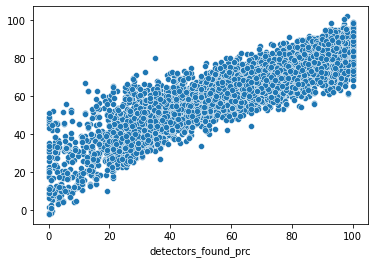

-----Test Performance ----- 
Test RMSE: 13.104843908072416
Test MAE: 9.787615469298801


C:\Users\cle9a\anaconda3\envs\rcp2Lite\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


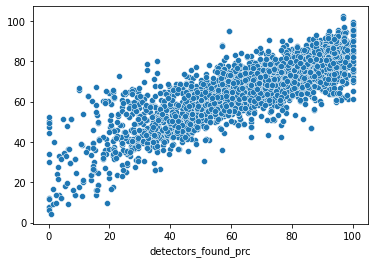

Test Correlation: (0.8205256761162569, 0.0)
Test R-squared: 0.6430589432592726

 Feature ranking:
1. RPL_THEME1 (0.277190)
2. RPL_THEME3 (0.188507)
3. RPL_THEME2 (0.176217)
4. RPL_THEME4 (0.173049)
5. Population Density (per square mile), 2010 (0.147094)
6. inc_pct_poverty (0.037943)


In [56]:
svi_use = True
smoke_prediction = Smoke.trainModels(ARC,ACS,SVI, ACS_cols_to_use,svi_use, utils.DATA['data'])

In [57]:
out = NFIRS.fires.copy()
# add final invidual predictors 

out.columns =  'fires_per_1K_pop_' + out.columns
cols = out.columns

In [58]:
out = ACS.data.merge(out, how = 'left', left_index = True, right_index = True)
out = out[cols]

In [59]:
# Smoke Alarm model munging 


# add number of surveys recorded at the block level
num_surveys_block = Smoke.models['Block_Group']['num_surveys'].copy()
num_surveys_block.index = num_surveys_block.index.str[2:]


out['recorded_home_visits'] = num_surveys_block


# add the statistical model outputs 
Smoke_predicts = Smoke.models['MultiLevel'][
    [ 'detectors_working_prc','detectors_working_CI','geography']].copy()
Smoke_predicts.index = Smoke_predicts.index.str[2:]
out = out.merge(Smoke_predicts,how = 'left', left_index = True, right_index = True)

## add DL model to outputs
DL = pd.DataFrame(smoke_prediction['Population Density (per square mile), 2010'])
DL['detectors_predicted'] = smoke_prediction['Predictions'].copy()

out = out.merge(DL,how = 'left', left_index = True, right_index = True)

In [60]:
out['smoke_detector_risk_frac'] =  1 - out['detectors_predicted'] / 100
out['smoke_detector_risk_score'] =  out['smoke_detector_risk_frac'].rank(pct=True)
out[['smoke_detector_risk_frac','smoke_detector_risk_score']]

,smoke_detector_risk_frac,smoke_detector_risk_score
GEOID,,
010010201001,0.238615,0.322542
010010201002,0.209849,0.234809
010010202001,0.347021,0.666022
010010202002,0.323694,0.596632
010010203001,0.320459,0.586822
...,...,...
560459511001,0.399114,0.794991
560459511002,0.399114,0.794991
560459513001,0.293346,0.500331


In [61]:
out['SVI_Theme_1'] = SVI.data['RPL_THEME1'].replace(-999.0, np.NaN)
out['fire_propensity_risk_score'] = FPM.test_prediction_probs[:,1]
out['fire_severity_risk_score'] = FSM.test_prediction_probs[:,1]



In [62]:
# create and add final predictor 

#create fire_risk_score by weighing propensity and severity at a .8 to .2 ratio.
#We want the fire_risk_score to be half of the overall combinedRiskScore so multiple the fire_risk_score by 2.
out['fire_prop_weighted'] = out['fire_propensity_risk_score']*0.8
out['fire_sev_weighted'] = out['fire_severity_risk_score']*0.2
out['fire_risk_score'] = out.loc[:,['fire_prop_weighted', 'fire_sev_weighted']].mean(axis = 1, skipna = True)
out['fire_risk_score'] = out['fire_risk_score']*2

out['CombinedRiskScore'] =  out.loc[:,['smoke_detector_risk_score',
                                       'SVI_Theme_1',
                                       'fire_prop_weighted',
                                       'fire_sev_weighted'] ].mean(axis = 1, skipna = True) #False )

In [63]:
out['CombinedRiskScore'].describe()

count    217739.000000
mean          0.405799
std           0.213880
min           0.001221
25%           0.241696
50%           0.385658
75%           0.545892
max           0.993081
Name: CombinedRiskScore, dtype: float64

In [64]:
out_name = f"CombinedModels-basic{date.today()}.csv"
out_save = out.copy()
out_save.index = '#_' + out_save.index
out_save.to_csv(utils.DATA['model-outputs'] / out_name)

In [65]:
# alternate risk score ideas 

#out['CombinedRiskScore'] = (out[["fire_severity_risk_score", "fire_propensity_risk_score"]].max(axis=1) + out['smoke_detector_risk_score'])*100

In [66]:
out_columns = ['state','NFIRS_start','NFIRS_end','years_fires_reported','total_fires_reported', 'max_fires_1k', 
               'median_fires_1k','total_fires_reported_sev', 'max_fires_1k_sev', 'median_fires_1k_sev',
               'fire_propensity_risk_score','fire_severity_risk_score','fire_risk_score', 'recorded_home_visits',
              'smoke_detector_risk_frac', 'smoke_detector_risk_score','geography', 'SVI_Theme_1','CombinedRiskScore',
              'did_not_work_past_12_mo', 'house_pct_live_alone', 'pct_alt_heat', 'house_yr_pct_before_1960', 
               'inc_pct_poverty', 'race_pct_black_or_amind', 'tot_population', 'house_tot_occ_cnt', 'inc_pcincome', 
               'inc_hhmean', 'race_pct_white', 'race_pct_whitenh','race_pct_whiteh', 'race_pct_nwhitenh', 
               'race_pct_hisp',  'race_pct_black', 'race_pct_amind',  'race_pct_asian', 'race_pct_napi', 'race_pct_other', 
               'race_pct_two+','age_pct_under25', 'age_pct_over65',  'disability_pct', 'snap_past_12_mo', 'single_unit_home', 
               'multi_unit_home', 'mobile_home', 'boat_van_rv_home', 'spanish_speaking']

In [67]:
years = FSM.years_used
years

array(['2011', '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype=object)

In [68]:
out['NFIRS_start'] = min(years)
out['NFIRS_start'] = out['NFIRS_start'].astype(int)
out['NFIRS_end'] = max(years)
out['NFIRS_end'] = out['NFIRS_end'].astype(int)
out

,fires_per_1K_pop_2009,fires_per_1K_pop_2010,fires_per_1K_pop_2011,fires_per_1K_pop_2012,fires_per_1K_pop_2013,fires_per_1K_pop_2014,fires_per_1K_pop_2015,fires_per_1K_pop_2016,fires_per_1K_pop_2017,recorded_home_visits,...,smoke_detector_risk_score,SVI_Theme_1,fire_propensity_risk_score,fire_severity_risk_score,fire_prop_weighted,fire_sev_weighted,fire_risk_score,CombinedRiskScore,NFIRS_start,NFIRS_end
GEOID,,,,,,,,,,,,,,,,,,,,,
010010201001,1.342282,2.684564,NaN,NaN,NaN,NaN,NaN,1.342282,1.342282,0,...,0.322542,0.3913,0.278164,0.816859,0.445063,0.326744,0.385903,0.371412,2011,2017
010010201002,1.581028,0.790514,NaN,1.581028,0.790514,NaN,1.581028,0.790514,NaN,0,...,0.234809,0.3913,0.079479,0.037421,0.127166,0.014968,0.071067,0.192061,2011,2017
010010202001,1.047120,NaN,3.141361,NaN,1.047120,1.047120,1.047120,1.047120,NaN,0,...,0.666022,0.7065,0.678772,0.796419,1.086035,0.318568,0.702301,0.694281,2011,2017
010010202002,2.832861,2.832861,2.832861,0.944287,0.944287,NaN,0.944287,NaN,3.777148,0,...,0.596632,0.7065,0.134161,0.301321,0.214658,0.120529,0.167593,0.409579,2011,2017
010010203001,0.846024,1.269036,0.846024,0.423012,1.269036,0.423012,0.423012,0.846024,NaN,0,...,0.586822,0.5659,0.002346,0.002481,0.003753,0.000992,0.002373,0.289367,2011,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560459511001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.372684,NaN,0,...,0.794991,0.3925,0.268031,0.294215,0.428850,0.117686,0.273268,0.433507,2011,2017
560459511002,0.632111,NaN,NaN,NaN,NaN,NaN,0.632111,NaN,NaN,0,...,0.794991,0.3925,0.262987,0.359560,0.420779,0.143824,0.282301,0.438023,2011,2017
560459513001,0.868810,NaN,0.868810,NaN,0.868810,0.868810,NaN,NaN,1.737619,3,...,0.500331,0.5093,0.024417,0.661153,0.039068,0.264461,0.151764,0.328290,2011,2017


In [69]:
fires_trained = NFIRS.fires_noAdjustment[years]
fires_trained2 = fires_trained>0
fires_trained2['years_fires_reported']= fires_trained2.sum(axis = 1)
fires_trained2 = fires_trained2['years_fires_reported']
out = out.merge(fires_trained2, how = 'left', left_index = True, right_index = True)

fires_trained = NFIRS.fires_noAdjustment[years]
fires_trained['total_fires_reported'] = fires_trained.sum(axis = 1)
fires_trained = fires_trained['total_fires_reported']
out = out.merge(fires_trained, how = 'left', left_index = True, right_index = True)

fires_trained = NFIRS.fires[years]
fires_trained2 = np.nanmax(fires_trained, axis =1)
fires_trained['max_fires_1k'] = fires_trained2
fires_trained2 = fires_trained['max_fires_1k']
out = out.merge(fires_trained2, how = 'left', left_index = True, right_index = True)

fires_trained = NFIRS.fires[years]
fires_trained2 = np.nanmedian(fires_trained, axis =1)
fires_trained['median_fires_1k'] = fires_trained2
fires_trained2 = fires_trained['median_fires_1k']
out = out.merge(fires_trained2, how = 'left', left_index = True, right_index = True)
out

C:\Users\cle9a\anaconda3\envs\rcp2Lite\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\cle9a\anaconda3\envs\rcp2Lite\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: All-NaN axis encountered
  del sys.path[0]
C:\Users\cle9a\anaconda3\envs\rcp2Lite\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\cle9a\anaconda3\envs\rcp2Lite\lib\site-packages\numpy\lib\nanfunctions.py:1120: RuntimeWarning: All-Na

,fires_per_1K_pop_2009,fires_per_1K_pop_2010,fires_per_1K_pop_2011,fires_per_1K_pop_2012,fires_per_1K_pop_2013,fires_per_1K_pop_2014,fires_per_1K_pop_2015,fires_per_1K_pop_2016,fires_per_1K_pop_2017,recorded_home_visits,...,fire_prop_weighted,fire_sev_weighted,fire_risk_score,CombinedRiskScore,NFIRS_start,NFIRS_end,years_fires_reported,total_fires_reported,max_fires_1k,median_fires_1k
GEOID,,,,,,,,,,,,,,,,,,,,,
010010201001,1.342282,2.684564,NaN,NaN,NaN,NaN,NaN,1.342282,1.342282,0,...,0.445063,0.326744,0.385903,0.371412,2011,2017,2.0,2.0,1.342282,1.342282
010010201002,1.581028,0.790514,NaN,1.581028,0.790514,NaN,1.581028,0.790514,NaN,0,...,0.127166,0.014968,0.071067,0.192061,2011,2017,4.0,6.0,1.581028,1.185771
010010202001,1.047120,NaN,3.141361,NaN,1.047120,1.047120,1.047120,1.047120,NaN,0,...,1.086035,0.318568,0.702301,0.694281,2011,2017,5.0,7.0,3.141361,1.047120
010010202002,2.832861,2.832861,2.832861,0.944287,0.944287,NaN,0.944287,NaN,3.777148,0,...,0.214658,0.120529,0.167593,0.409579,2011,2017,5.0,10.0,3.777148,0.944287
010010203001,0.846024,1.269036,0.846024,0.423012,1.269036,0.423012,0.423012,0.846024,NaN,0,...,0.003753,0.000992,0.002373,0.289367,2011,2017,6.0,10.0,1.269036,0.634518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560459511001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.372684,NaN,0,...,0.428850,0.117686,0.273268,0.433507,2011,2017,1.0,2.0,1.372684,1.372684
560459511002,0.632111,NaN,NaN,NaN,NaN,NaN,0.632111,NaN,NaN,0,...,0.420779,0.143824,0.282301,0.438023,2011,2017,1.0,1.0,0.632111,0.632111
560459513001,0.868810,NaN,0.868810,NaN,0.868810,0.868810,NaN,NaN,1.737619,3,...,0.039068,0.264461,0.151764,0.328290,2011,2017,4.0,5.0,1.737619,0.868810


In [70]:
fires_trained = NFIRS_Sev.fires[years]
fires_trained['total_fires_reported_sev'] = fires_trained.sum(axis = 1)
fires_trained = fires_trained['total_fires_reported_sev']
out = out.merge(fires_trained, how = 'left', left_index = True, right_index = True)

fires_trained = NFIRS_Sev.fires[years]
fires_trained2 = np.nanmax(fires_trained, axis =1)
fires_trained['max_fires_1k_sev'] = fires_trained2
fires_trained2 = fires_trained['max_fires_1k_sev']
out = out.merge(fires_trained2, how = 'left', left_index = True, right_index = True)

fires_trained = NFIRS_Sev.fires[years]
fires_trained2 = np.nanmedian(fires_trained, axis =1)
fires_trained['median_fires_1k_sev'] = fires_trained2
fires_trained2 = fires_trained['median_fires_1k_sev']
out = out.merge(fires_trained2, how = 'left', left_index = True, right_index = True)
out

C:\Users\cle9a\anaconda3\envs\rcp2Lite\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\cle9a\anaconda3\envs\rcp2Lite\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: All-NaN axis encountered
  import sys
C:\Users\cle9a\anaconda3\envs\rcp2Lite\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\cle9a\anaconda3\envs\rcp2Lite\lib\site-packages\numpy\lib\nanfunctions.py:1120: RuntimeWarning: All-NaN slice

,fires_per_1K_pop_2009,fires_per_1K_pop_2010,fires_per_1K_pop_2011,fires_per_1K_pop_2012,fires_per_1K_pop_2013,fires_per_1K_pop_2014,fires_per_1K_pop_2015,fires_per_1K_pop_2016,fires_per_1K_pop_2017,recorded_home_visits,...,CombinedRiskScore,NFIRS_start,NFIRS_end,years_fires_reported,total_fires_reported,max_fires_1k,median_fires_1k,total_fires_reported_sev,max_fires_1k_sev,median_fires_1k_sev
GEOID,,,,,,,,,,,,,,,,,,,,,
010010201001,1.342282,2.684564,NaN,NaN,NaN,NaN,NaN,1.342282,1.342282,0,...,0.371412,2011,2017,2.0,2.0,1.342282,1.342282,2.684564,1.342282,1.342282
010010201002,1.581028,0.790514,NaN,1.581028,0.790514,NaN,1.581028,0.790514,NaN,0,...,0.192061,2011,2017,4.0,6.0,1.581028,1.185771,1.581028,0.790514,0.790514
010010202001,1.047120,NaN,3.141361,NaN,1.047120,1.047120,1.047120,1.047120,NaN,0,...,0.694281,2011,2017,5.0,7.0,3.141361,1.047120,2.094241,1.047120,1.047120
010010202002,2.832861,2.832861,2.832861,0.944287,0.944287,NaN,0.944287,NaN,3.777148,0,...,0.409579,2011,2017,5.0,10.0,3.777148,0.944287,2.832861,1.888574,1.416431
010010203001,0.846024,1.269036,0.846024,0.423012,1.269036,0.423012,0.423012,0.846024,NaN,0,...,0.289367,2011,2017,6.0,10.0,1.269036,0.634518,2.115059,0.423012,0.423012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560459511001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.372684,NaN,0,...,0.433507,2011,2017,1.0,2.0,1.372684,1.372684,1.372684,1.372684,1.372684
560459511002,0.632111,NaN,NaN,NaN,NaN,NaN,0.632111,NaN,NaN,0,...,0.438023,2011,2017,1.0,1.0,0.632111,0.632111,0.000000,NaN,NaN
560459513001,0.868810,NaN,0.868810,NaN,0.868810,0.868810,NaN,NaN,1.737619,3,...,0.328290,2011,2017,4.0,5.0,1.737619,0.868810,0.000000,NaN,NaN


In [71]:
ACS_toCombine = ACS.data
#check this makes sense
ACS_toCombine['inc_hhmean'] = ACS_toCombine['inc_pcincome']*ACS_toCombine['tot_population']/ACS_toCombine['house_tot_occ_cnt']
ACS_toCombine['inc_hhmean'] = ACS_toCombine['inc_hhmean'].round()
ACS_toCombine['race_pct_whiteh'] = ACS_toCombine['race_pct_white']-ACS_toCombine['race_pct_whitenh']
ACS_toCombine['race_pct_nwhitenh'] = 1-ACS_toCombine['race_pct_hisp']-ACS_toCombine['race_pct_whitenh']
ACS_toCombine['race_pct_nwhitenh'] = ACS_toCombine['race_pct_nwhitenh'].round(5)


ACS_keep = ACS_toCombine[['state',
    'did_not_work_past_12_mo', 'house_pct_live_alone', 'pct_alt_heat', 'house_yr_pct_before_1960', 
    'inc_pct_poverty', 'race_pct_black_or_amind', 'tot_population', 'house_tot_occ_cnt', 'inc_pcincome', 
    'inc_hhmean', 'race_pct_white', 'race_pct_whitenh','race_pct_whiteh', 'race_pct_nwhitenh', 
    'race_pct_hisp',  'race_pct_black', 'race_pct_amind',  'race_pct_asian', 'race_pct_napi', 'race_pct_other', 
    'race_pct_two+','age_pct_under25', 'age_pct_over65',  'disability_pct', 'snap_past_12_mo', 'single_unit_home', 
    'multi_unit_home', 'mobile_home', 'boat_van_rv_home', 'spanish_speaking'
    ]]
ACS_keep = ACS_keep.replace(-666666666.0, np.nan)
ACS_keep = ACS_keep.replace(np.inf, np.nan)

In [72]:
out = out.merge(ACS_keep, how = 'left', left_index = True, right_index = True)
out

,fires_per_1K_pop_2009,fires_per_1K_pop_2010,fires_per_1K_pop_2011,fires_per_1K_pop_2012,fires_per_1K_pop_2013,fires_per_1K_pop_2014,fires_per_1K_pop_2015,fires_per_1K_pop_2016,fires_per_1K_pop_2017,recorded_home_visits,...,race_pct_two+,age_pct_under25,age_pct_over65,disability_pct,snap_past_12_mo,single_unit_home,multi_unit_home,mobile_home,boat_van_rv_home,spanish_speaking
GEOID,,,,,,,,,,,,,,,,,,,,,
010010201001,1.342282,2.684564,NaN,NaN,NaN,NaN,NaN,1.342282,1.342282,0,...,0.000000,0.363758,0.036242,0.239437,0.183099,0.820423,0.024648,0.154930,0.000000,0.102113
010010201002,1.581028,0.790514,NaN,1.581028,0.790514,NaN,1.581028,0.790514,NaN,0,...,0.054545,0.348617,0.114625,0.278509,0.096491,0.925054,0.000000,0.074946,0.000000,0.046053
010010202001,1.047120,NaN,3.141361,NaN,1.047120,1.047120,1.047120,1.047120,NaN,0,...,0.018750,0.372917,0.161458,0.458549,0.303109,0.768844,0.201005,0.030151,0.000000,0.000000
010010202002,2.832861,2.832861,2.832861,0.944287,0.944287,NaN,0.944287,NaN,3.777148,0,...,0.012945,0.303398,0.094660,0.280973,0.172566,0.821138,0.168699,0.010163,0.000000,0.011062
010010203001,0.846024,1.269036,0.846024,0.423012,1.269036,0.423012,0.423012,0.846024,NaN,0,...,0.035956,0.302876,0.134095,0.379854,0.082524,0.995112,0.000000,0.004888,0.000000,0.037621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560459511001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.372684,NaN,0,...,0.049417,0.234043,0.175704,0.219941,0.054252,0.711035,0.053470,0.228669,0.006826,0.000000
560459511002,0.632111,NaN,NaN,NaN,NaN,NaN,0.632111,NaN,NaN,0,...,0.004849,0.208513,0.215517,0.276139,0.010724,0.706250,0.000000,0.293750,0.000000,0.009383
560459513001,0.868810,NaN,0.868810,NaN,0.868810,0.868810,NaN,NaN,1.737619,3,...,0.000000,0.325804,0.076455,0.210325,0.172084,0.709910,0.054054,0.236036,0.000000,0.000000


In [73]:
out_final = out[out_columns]
out_final

,state,NFIRS_start,NFIRS_end,years_fires_reported,total_fires_reported,max_fires_1k,median_fires_1k,total_fires_reported_sev,max_fires_1k_sev,median_fires_1k_sev,...,race_pct_two+,age_pct_under25,age_pct_over65,disability_pct,snap_past_12_mo,single_unit_home,multi_unit_home,mobile_home,boat_van_rv_home,spanish_speaking
GEOID,,,,,,,,,,,,,,,,,,,,,
010010201001,AL,2011,2017,2.0,2.0,1.342282,1.342282,2.684564,1.342282,1.342282,...,0.000000,0.363758,0.036242,0.239437,0.183099,0.820423,0.024648,0.154930,0.000000,0.102113
010010201002,AL,2011,2017,4.0,6.0,1.581028,1.185771,1.581028,0.790514,0.790514,...,0.054545,0.348617,0.114625,0.278509,0.096491,0.925054,0.000000,0.074946,0.000000,0.046053
010010202001,AL,2011,2017,5.0,7.0,3.141361,1.047120,2.094241,1.047120,1.047120,...,0.018750,0.372917,0.161458,0.458549,0.303109,0.768844,0.201005,0.030151,0.000000,0.000000
010010202002,AL,2011,2017,5.0,10.0,3.777148,0.944287,2.832861,1.888574,1.416431,...,0.012945,0.303398,0.094660,0.280973,0.172566,0.821138,0.168699,0.010163,0.000000,0.011062
010010203001,AL,2011,2017,6.0,10.0,1.269036,0.634518,2.115059,0.423012,0.423012,...,0.035956,0.302876,0.134095,0.379854,0.082524,0.995112,0.000000,0.004888,0.000000,0.037621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560459511001,WY,2011,2017,1.0,2.0,1.372684,1.372684,1.372684,1.372684,1.372684,...,0.049417,0.234043,0.175704,0.219941,0.054252,0.711035,0.053470,0.228669,0.006826,0.000000
560459511002,WY,2011,2017,1.0,1.0,0.632111,0.632111,0.000000,NaN,NaN,...,0.004849,0.208513,0.215517,0.276139,0.010724,0.706250,0.000000,0.293750,0.000000,0.009383
560459513001,WY,2011,2017,4.0,5.0,1.737619,0.868810,0.000000,NaN,NaN,...,0.000000,0.325804,0.076455,0.210325,0.172084,0.709910,0.054054,0.236036,0.000000,0.000000


In [74]:
a = out.describe()
a.to_csv(utils.DATA['model-outputs']/f"summary-pop0-{date.today()}.csv")

In [75]:
out_name = f"CombinedModels-FileStructureColumns-pop0-{date.today()}.csv"
out_final.index = '#_' + out_final.index
out_final.to_csv(utils.DATA['model-outputs'] / out_name)